# Introduction

In this assignment, we practice implementing a basic form of neural network algorithm. We are provided with two sets of data, one on handwritten digits recognition, the other is the usual fishing data. The focus is on the first. The fishing data is presented as an exercise on categorical data.

# Data

The handwritten digits datasets seems to be a variation on a subset the MNIST data. Instead of the 28 by 28 pixel grid, we have a compressed 8 by 8 grid in our handwritten digits datasets. There are 3823 rows in the training set and 1797 in testing, which are rather small datasets (bigger than the fishing sets, but still very small) for neural networks. That makes performance less of a concern. However, depending on implementation details, large numbers of matrix operations can still slow down our training.

In [1]:
import pandas as pd
import numpy as np

# import data
fishing = pd.read_csv("../data/fishing(1).data", header=None, names=('Wind', 'Air', 'Water', 'Sky', 'Fishing'))
fishing_training = fishing.iloc[:14,:]
fishing_testing = fishing.iloc[15:,:]
# outcome values are assigned based on the tutorial on decision tree
fishing_testing['Fishing'] = ['Yes', 'No']
digits_training = pd.read_csv("../data/digits-train.data", header=None)
digits_testing = pd.read_csv("../data/digits-test.data", header=None)

<ipython-input-1-89c483734f3d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fishing_testing['Fishing'] = ['Yes', 'No']


One thing to note is, in the above example, changing the values in fishing_testing changes the values in fishing as well, because iloc actually returns references, not new objects.

# implementation

Although optimization is not part of the goal for this assignment, experiment was attempted using the @njit decorator in the Numba package, which translates decorated python code into fast machine code using LLVM.

Results show significant improvement when compared with the version not decorated with @njit. Still, the usual caution applies: vector operations are preferred over loops. Replacing a loop with np.out() in the update_weights() function significantly improved the runtime of the current model.

In the current implementation of training, 20 epochs takes about a bit over 1s to run.

In [2]:
# njit instructs that the decorated function be compiled so that it runs without involving the Python interpreter
# prange parallels loops
from numba import njit, prange

@njit(parallel=True)
def min_max_normalize(narr):
    # initialize array of size narr transposed
    new_narr = np.full((narr.shape[1], narr.shape[0]), 0.0)
    # transpose input array
    narr = narr.T

    for i in prange(narr.shape[0]):
        min_val = np.min(narr[i])
        max_val = np.max(narr[i])
        diff = max_val - min_val
        for j in prange(narr.shape[1]):
            if diff == 0:
                # normalize to 0 when values are the same
                new_narr[i,j] = 0
            else:
                new_narr[i,j] = (narr[i,j] - min_val)/diff

    return new_narr.T

In [3]:
@njit
def get_small_rand(length):
    # get random numbers of length length, between -0.001 and 0.001
    return np.random.uniform(-0.001, 0.001, size=(length,))

# activation functions

@njit
def get_sum_of_prod(vec, weights):
    # ascontiguousarray is supposed to speed up matrix operations
    vec = np.ascontiguousarray(vec)
    weights = np.ascontiguousarray(weights)
    return np.dot(vec, weights)

@njit
def activation_binary_sigmoid(sop):
    return 1 / (1 + np.exp(-sop))

@njit
def activation_softmax(sop):
    # sop - np.max(sop) is intended to make softmax more stable, less likely to return NANs
    ex = np.exp(sop - np.max(sop))
    return ex/np.sum(ex)

In [4]:
@njit
def feed_forward_to_hidden(vec, weights):
    sop = get_sum_of_prod(vec, weights)
    # use binary sigmoid for activation in the hidden layer
    out = activation_binary_sigmoid(sop)
    return out

@njit
def feed_forward_to_output(vec, weights):
    sop = get_sum_of_prod(vec, weights)
    # use softmax for activation in the output layer
    out = activation_softmax(sop)
    return out

In [5]:
@njit
def get_rmse(t_vec, y_vec):
    # use root mean squared error as one error measurement
    return np.sqrt(np.sum(np.square(np.subtract(t_vec, y_vec))))/len(t_vec)

@njit
def get_cross_entropy_loss(t_vec, y_vec):
    # use cross entropy/log loss as another error measurement
    return -np.dot(t_vec, np.log(y_vec))

# @njit
# def get_sigmoid_loss(t_vec, y_vec):
#     d = y_vec * (1 - y_vec)
#     e = t_vec - y_vec
#     return d * e

@njit
def get_out_error(t_vec, y_vec):
    # derivative of cross entropy loss
    return  t_vec - y_vec

@njit
def get_hidden_error(h, w_vec, e_vec):
    # derivative of sigmoid
    h_d = h * (1 - h)
    w_e_dot = np.dot(w_vec, e_vec)
    return h_d * w_e_dot

In [6]:
@njit
def update_weights(error, weights, outs, learning_rate):
    temp = learning_rate * error
    adjustments = np.outer(outs, temp)
    return weights + adjustments

In [7]:
@njit
def train_neural_net(X, Y, epoch=1, number_of_hidden_nodes=50, learning_rate=0.05):

    input_n_row = X.shape[0]
    input_n_col = X.shape[1]
    # create array of 1s
    temp_arr = np.array(([1.0] * input_n_row))
    # prepend 1 to each instance
    new_input = np.concatenate((temp_arr.reshape(1,input_n_row), X.T)).T

    # use random number between -.001 and .001 as input weights
    # 65 because 64 inputs and 1 bias
    # 50 because 50 hidden nodes
    input_weights = np.reshape(get_small_rand((input_n_col + 1) * number_of_hidden_nodes), (input_n_col + 1, number_of_hidden_nodes))

    # similarly for hidden layer weights
    # 51 because 50 nodes (2/3 of the sum of input and output nodes) and 1 more for bias
    # 10 because 10 output nodes
    hidden_weights = np.reshape(get_small_rand((number_of_hidden_nodes + 1) * Y.shape[1]), (number_of_hidden_nodes + 1, Y.shape[1]))

    # initialize arrays for rmse and cross entropy error
    rmse = np.zeros((epoch,))
    ce = np.zeros((epoch,))

    for i in range(epoch):
        # this may not be the right way to do it (should've assigned length as well)
        # but the intention is to assign memory space for an array
        # and then update values
        # which is supposed to be faster than appending
        target = np.array([0.])
        y_hat = np.array([0.])
        for row in range(X.shape[0]):
            # outputs at hidden nodes
            hidden_outs = feed_forward_to_hidden(new_input[row], input_weights)
            # prepend 1 as bias
            new_hidden_outs = np.concatenate((np.array([1.0]), hidden_outs))
            # current output
            y_hat = feed_forward_to_output(new_hidden_outs, hidden_weights)
            # current target
            target = Y[row]
            # output error
            output_error = get_out_error(target, y_hat)
            # hidden error
            hidden_error = get_hidden_error(hidden_outs, hidden_weights[1:], output_error)
            # update hidden weights
            new_hidden_weights = update_weights(output_error,hidden_weights, new_hidden_outs, learning_rate)
            hidden_weights = new_hidden_weights
            # update input weights
            new_input_weights = update_weights(hidden_error,input_weights, new_input[row], learning_rate)
            input_weights = new_input_weights
        # current rmse and cross entropy error
        current_rmse = get_rmse(target, y_hat)
        current_ce = get_cross_entropy_loss(target, y_hat)
        rmse[i] = current_rmse
        ce[i] = current_ce

    return input_weights, hidden_weights, rmse, ce

Numba translation of Python code needs to convert dynamic types to their static equivalents. To avoid potential problems of type inference, we convert data types of all sets to float. We also normalize feature variables using min_max.

In [8]:
train_input = digits_training.iloc[:,:-1].to_numpy(dtype=float)
train_output = pd.get_dummies(digits_training.iloc[:,-1]).to_numpy(dtype=float)
train_input_normalized = min_max_normalize(train_input)

test_input = digits_testing.iloc[:,:-1].to_numpy(dtype=float)
test_output = pd.get_dummies(digits_testing.iloc[:,-1]).to_numpy(dtype=float)
test_input_normalized = min_max_normalize(test_input)

In [9]:
%timeit train_neural_net(train_input_normalized, train_output, epoch=50)

1.33 s ± 9.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As shown above, 20 epochs training takes a bit over 1 second.

<AxesSubplot:title={'center':'Cross Entropy Loss by Epochs'}>

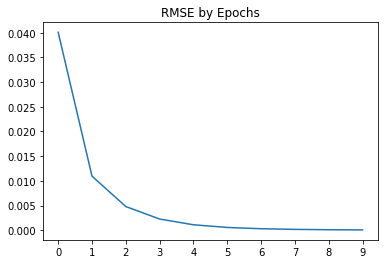

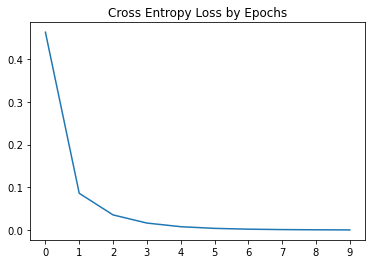

In [10]:
test = train_neural_net(train_input_normalized, train_output, epoch=10)

pd.DataFrame(test[2]).plot(title='RMSE by Epochs', legend=None, xticks=list(range(10)))

pd.DataFrame(test[3]).plot(title='Cross Entropy Loss by Epochs', legend=None, xticks=list(range(10)))

As we could see, both measurements of errors flatten after 4 or 5 epochs.

In [11]:
def neural_net_predict(input_ws, hidden_ws, X, Y):
    # number of rows in the input
    input_n_row = X.shape[0]
    # initialize bias
    temp_arr = np.array(([1.0] * input_n_row))
    # add bias to input
    new_X = np.concatenate((temp_arr.reshape(1,input_n_row), X.T)).T
    # get hidden output
    hidden_outs = feed_forward_to_hidden(new_X, input_ws)
    # add bias
    new_hidden_outs = np.concatenate((np.array([1.0]*input_n_row).reshape(1,input_n_row), hidden_outs.T)).T
    # get final output
    outs = feed_forward_to_output(new_hidden_outs, hidden_ws)
    # get prediction with max prob
    preds = outs.argmax(1)
    # return accuracy
    return np.sum(preds == Y) / input_n_row

In [12]:
weights = train_neural_net(train_input_normalized, train_output, epoch=10)

accuracy_training = neural_net_predict(weights[0], weights[1], train_input_normalized, digits_training.iloc[:,-1].to_numpy())
print("Training Accuracy: " + str(accuracy_training))
accuracy_testing = neural_net_predict(weights[0], weights[1], test_input_normalized, digits_testing.iloc[:,-1].to_numpy())
print("Testing Accuracy: " + str(accuracy_testing))

Training Accuracy: 0.9806434737117447
Testing Accuracy: 0.9465776293823038


With 10 epochs, we already get an accuracy of 98% for training and 95% for testing.

In [13]:
weights = train_neural_net(train_input_normalized, train_output, epoch=100)

accuracy_training = neural_net_predict(weights[0], weights[1], train_input_normalized, digits_training.iloc[:,-1].to_numpy())
print("Training Accuracy: " + str(accuracy_training))
accuracy_testing = neural_net_predict(weights[0], weights[1], test_input_normalized, digits_testing.iloc[:,-1].to_numpy())
print("Testing Accuracy: " + str(accuracy_testing))

Training Accuracy: 1.0
Testing Accuracy: 0.9616026711185309


Increasing the number of epochs to 100 does not seem to improve testing accuracy by a lot. However, the base testing accuracy is already high enough, so it is not surprising that improving beyond that is difficult.

Next, we use the classifier on the fishing data.

Since there is only a few instances in the fishing dataset, we encode the training and testing sets at the same time to avoid the case where the testing set contains category values not present in the training set. In fact, if we encode the training set and the testing set separately, we may not even be able to make correct predictions in principle, as one value for wind (light) only appears in testing.

In [14]:
fishing_train = pd.get_dummies(fishing.drop(14)).to_numpy(dtype=float)[:14]
fishing_train_input = fishing_train.T[:11].T
fishing_train_output = fishing_train.T[11:]

fishing_test = pd.get_dummies(fishing.drop(14)).to_numpy(dtype=float)[14:]
fishing_test_input = fishing_test.T[:11].T
fishing_test_output = fishing_test.T[11:]

<ipython-input-7-5317e5ead33d>:53: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  current_ce = get_cross_entropy_loss(target, y_hat)


<AxesSubplot:title={'center':'Cross Entropy Loss by Epochs'}>

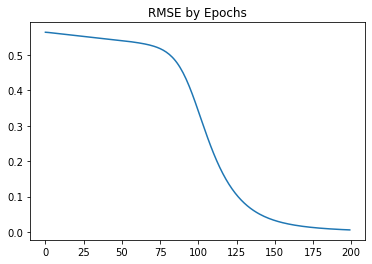

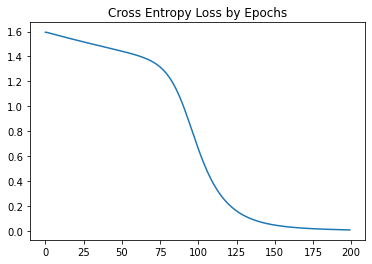

In [15]:
fishing_weights = train_neural_net(fishing_train_input, fishing_train_output.T, epoch=200)

pd.DataFrame(fishing_weights[2]).plot(title='RMSE by Epochs', legend=None)
pd.DataFrame(fishing_weights[3]).plot(title='Cross Entropy Loss by Epochs', legend=None)

From the error plots, we should expect good prediction results at closing to 200 epochs.

In [16]:
fishing_train_accuracy = neural_net_predict(fishing_weights[0], fishing_weights[1], fishing_train_input, fishing_train_output[1])
print("Training Accuracy: " + str(fishing_train_accuracy))
fishing_test_accuracy = neural_net_predict(fishing_weights[0], fishing_weights[1], fishing_test_input, fishing_test_output[1])
print("Testing Accuracy: " + str(fishing_test_accuracy))

Training Accuracy: 1.0
Testing Accuracy: 1.0


# Experiments

Having verified our implementation of a neural network classifier works, we now turn to an experiment.

To apply the neural network classifier on the fishing datasets, we need to convert the categorical data into numeric. Two similar encoding methods are worth mentioning: one-hot encoding and dummy encoding. One-hot encoding encodes each categorical value as a numeric value, whereas dummy encoding does the same except the numeric encoding is always one value less than the actually number of values in a category. See the difference below.

In [17]:
pd.get_dummies(fishing.drop(14)['Wind'])

,Light,Strong,Weak
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0
5,0,0,1
6,0,0,1
7,0,1,0
8,0,1,0
9,0,1,0


In [18]:
pd.get_dummies(fishing.drop(14)['Wind'], drop_first=True)

,Strong,Weak
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
5,0,1
6,0,1
7,1,0
8,1,0
9,1,0


Training Accuracy: 0.42857142857142855
Testing Accuracy: 0.5


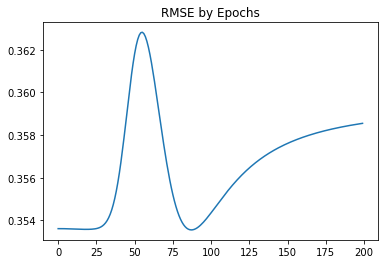

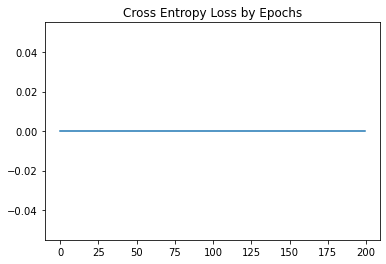

In [19]:
fishing_train = pd.get_dummies(fishing.drop(14), drop_first=True).to_numpy(dtype=float)[:14]
fishing_train_input = fishing_train.T[:6].T
fishing_train_output = fishing_train.T[6:]

fishing_test = pd.get_dummies(fishing.drop(14), drop_first=True).to_numpy(dtype=float)[14:]
fishing_test_input = fishing_test.T[:6].T
fishing_test_output = fishing_test.T[6:]

fishing_weights = train_neural_net(fishing_train_input, fishing_train_output.T, epoch=200)

pd.DataFrame(fishing_weights[2]).plot(title='RMSE by Epochs', legend=None)
pd.DataFrame(fishing_weights[3]).plot(title='Cross Entropy Loss by Epochs', legend=None)

fishing_train_accuracy = neural_net_predict(fishing_weights[0], fishing_weights[1], fishing_train_input, fishing_train_output[1])
print("Training Accuracy: " + str(fishing_train_accuracy))
fishing_test_accuracy = neural_net_predict(fishing_weights[0], fishing_weights[1], fishing_test_input, fishing_test_output[1])
print("Testing Accuracy: " + str(fishing_test_accuracy))

In our case, it seems using dummy encoding does not seem to help with the data we are working with, or there is some problem with the implementation presented here.